#This project is explained here:
https://www.pyimagesearch.com/2020/10/05/object-detection-bounding-box-regression-with-keras-tensorflow-and-deep-learning/



#Importing and Preparing Dataset:
Dataset used here is CALTECH-101.
We will use subset of this dataset, as we are trying to locate a single class only.

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [2]:
import tarfile

Extracting data to dataset folder:

In [3]:
with tarfile.open("/gdrive/MyDrive/CALTECH-101/101_ObjectCategories.tar.gz") as tar:
     tar.extractall("/content/dataset/")         

Extracting annotation to dataset folder:

In [4]:
with tarfile.open("/gdrive/MyDrive/CALTECH-101/Annotations.tar", "r") as gzip_file:
    gzip_file.extractall("/content/dataset/")

In [5]:
from scipy import io

mat = io.loadmat('/content/dataset/Annotations/Airplanes_Side_2/annotation_0001.mat')
#print(mat)

In [6]:
import glob

In [7]:
for p in glob.glob("/content/dataset/Annotations/Airplanes_Side_2"+ "/*.mat"):
	# load the bounding box associated with the path and update the width and height
	# lists
    name = p.split("/")[-1]
    name = "image"+name.split(".")[0][-5:]+".jpg"
    #print(name)
    (y, h, x, w) = io.loadmat(p)["box_coord"][0]
    #print(x,y,w,h)

Creating csv file:

In [8]:
data = []
for p in glob.glob("/content/dataset/Annotations/Airplanes_Side_2"+ "/*.mat"):
    name = p.split("/")[-1]
    name = "image"+name.split(".")[0][-5:]+".jpg"
    (y, h, x, w) = io.loadmat(p)["box_coord"][0]
    #print(name," ",x," ",y," ",w," ",h)
    data.append([name,x,y,w,h])
#print(data)

In [9]:
import pandas as pd

In [10]:
df = pd.DataFrame(data)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       800 non-null    object
 1   1       800 non-null    int64 
 2   2       800 non-null    int64 
 3   3       800 non-null    int64 
 4   4       800 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 31.4+ KB


In [12]:
df.head()

0   1   2    3    4
0  image_0641.jpg  56  28  349  133
1  image_0074.jpg  51  27  346  100
2  image_0563.jpg  52  31  346  112
3  image_0440.jpg  57  29  356  116
4  image_0779.jpg  27  27  350  117

In [13]:
df = df.sort_values(by = 0,ignore_index= True)
df.head(10)

0   1   2    3    4
0  image_0001.jpg  49  30  349  137
1  image_0002.jpg  59  35  342  153
2  image_0003.jpg  47  36  331  135
3  image_0004.jpg  47  24  342  141
4  image_0005.jpg  48  18  339  146
5  image_0006.jpg  48  24  344  126
6  image_0007.jpg  49  23  344  122
7  image_0008.jpg  51  29  344  119
8  image_0009.jpg  50  29  344  137
9  image_0010.jpg  55  32  335  106

In [14]:
df.to_csv('/content/dataset/airplanes.csv',header=False, index=False,)

In [15]:
!mv /content/dataset/101_ObjectCategories/airplanes /content/dataset

In [16]:
!mv /content/dataset/airplanes /content/dataset/images #renaming image file

mv: cannot move '/content/dataset/airplanes' to '/content/dataset/images/airplanes': Directory not empty


#Let's Start:

Declaring some variables:

In [17]:
# import the necessary packages
import os
# define the base path to the input dataset and then use it to derive
# the path to the images directory and annotation CSV file
BASE_PATH = "/content/dataset"
IMAGES_PATH = os.path.sep.join([BASE_PATH, "images"])
ANNOTS_PATH = os.path.sep.join([BASE_PATH, "airplanes.csv"])

In [18]:
BASE_OUTPUT = "/content/output"
# define the path to the output serialized model, model training plot,
# and testing image filenames
MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "detector.h5"])
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])
TEST_FILENAMES = os.path.sep.join([BASE_OUTPUT, "test_images.txt"])

In [19]:
# initialize our initial learning rate, number of epochs to train
# for, and the batch size
INIT_LR = 1e-4
NUM_EPOCHS = 25
BATCH_SIZE = 32

Importing Packages:

In [20]:
# import the necessary packages
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

Loading Data:

In [21]:
# load the contents of the CSV annotations file
print("[INFO] loading dataset...")
rows = open(ANNOTS_PATH).read().strip().split("\n")
# initialize the list of data (images), our target output predictions
# (bounding box coordinates), along with the filenames of the
# individual images
data = []
targets = []
filenames = []

[INFO] loading dataset...


In [22]:
# loop over the rows
for row in rows:
	# break the row into the filename and bounding box coordinates
	row = row.split(",")
	(filename, startX, startY, endX, endY) = row
    # derive the path to the input image, load the image (in OpenCV
	# format), and grab its dimensions
	imagePath = os.path.sep.join([IMAGES_PATH, filename])
	image = cv2.imread(imagePath)
	(h, w) = image.shape[:2]
	# scale the bounding box coordinates relative to the spatial
	# dimensions of the input image
	startX = float(startX) / w
	startY = float(startY) / h
	endX = float(endX) / w
	endY = float(endY) / h
    # load the image and preprocess it
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	# update our list of data, targets, and filenames
	data.append(image)
	targets.append((startX, startY, endX, endY))
	filenames.append(filename)

In [23]:
!mkdir /content/output

mkdir: cannot create directory ‘/content/output’: File exists


In [24]:
# convert the data and targets to NumPy arrays, scaling the input
# pixel intensities from the range [0, 255] to [0, 1]
data = np.array(data, dtype="float32") / 255.0
targets = np.array(targets, dtype="float32")
# partition the data into training and testing splits using 90% of
# the data for training and the remaining 10% for testing
split = train_test_split(data, targets, filenames, test_size=0.10,
	random_state=42)
# unpack the data split
(trainImages, testImages) = split[:2]
(trainTargets, testTargets) = split[2:4]
(trainFilenames, testFilenames) = split[4:]
# write the testing filenames to disk so that we can use then
# when evaluating/testing our bounding box regressor
print("[INFO] saving testing filenames...")
f = open(TEST_FILENAMES, "w")
f.write("\n".join(testFilenames))
f.close()

[INFO] saving testing filenames...


In [25]:
# load the VGG16 network, ensuring the head FC layers are left off
vgg = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
# freeze all VGG layers so they will *not* be updated during the
# training process
vgg.trainable = False
# flatten the max-pooling output of VGG
flatten = vgg.output
flatten = Flatten()(flatten)
# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid")(bboxHead)
# construct the model we will fine-tune for bounding box regression
model = Model(inputs=vgg.input, outputs=bboxHead)

In [26]:
# initialize the optimizer, compile the model, and show the model
# summary
opt = Adam(lr=INIT_LR)
model.compile(loss="mse", optimizer=opt,metrics=["accuracy"])
print(model.summary())
# train the network for bounding box regression
print("[INFO] training bounding box regressor...")
H = model.fit(
	trainImages, trainTargets,
	validation_data=(testImages, testTargets),
	batch_size=BATCH_SIZE,
	epochs=NUM_EPOCHS,
	verbose=1)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

[INFO] saving object detector model...


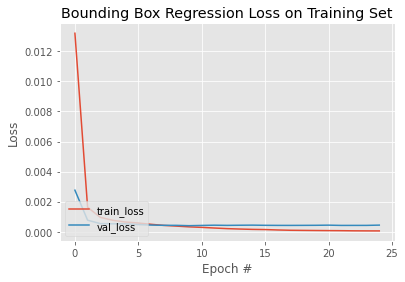

In [27]:
# serialize the model to disk
print("[INFO] saving object detector model...")
model.save(MODEL_PATH, save_format="h5")
# plot the model training history
N = NUM_EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Bounding Box Regression Loss on Training Set")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(PLOT_PATH)

In [28]:
with open('/content/output/test_images.txt') as f:
    test_filenames = f.read()

In [29]:
imagePaths = []
for f in test_filenames.split("\n"):
    # construct the full path to the image filename and then
    # update our image paths list
    p = os.path.sep.join([IMAGES_PATH, f])
    imagePaths.append(p)

In [30]:
#imagePaths

In [31]:
from tensorflow.keras.models import load_model
import imutils

[INFO] loading object detector...


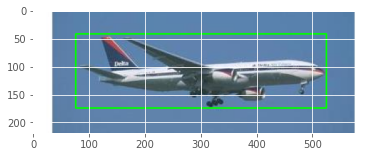

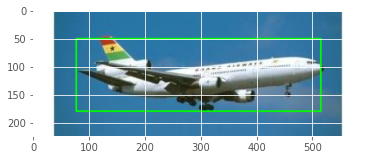

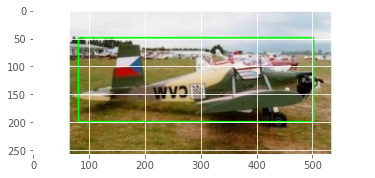

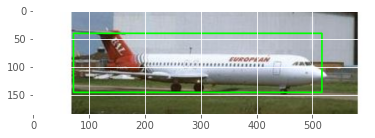

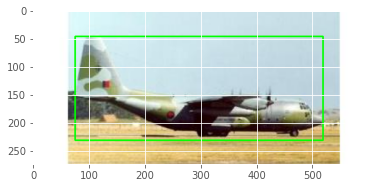

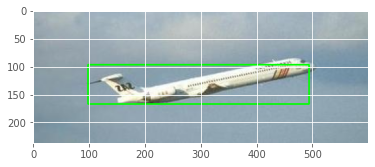

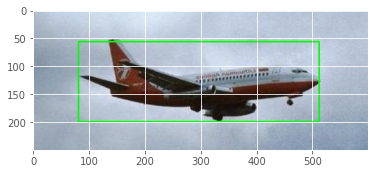

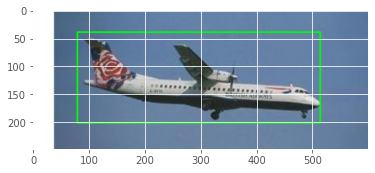

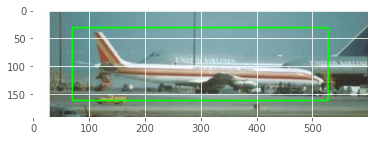

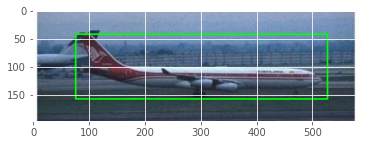

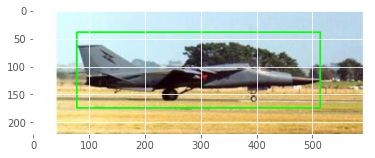

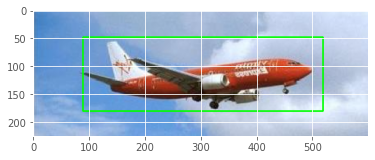

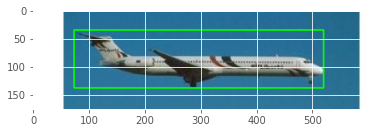

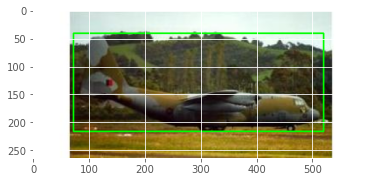

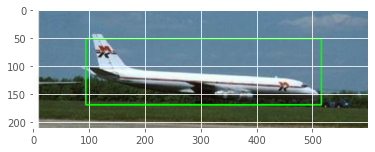

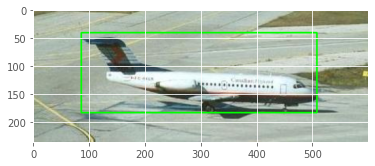

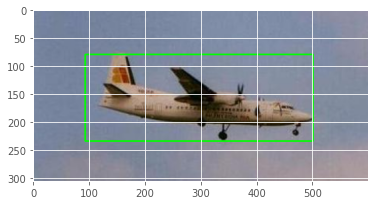

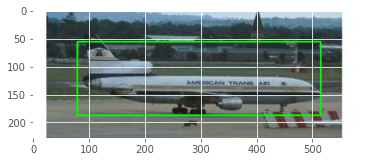

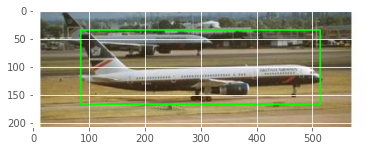

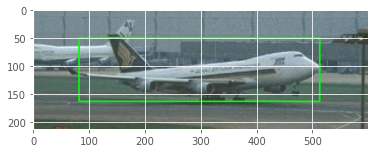

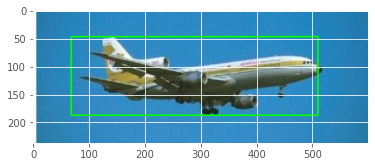

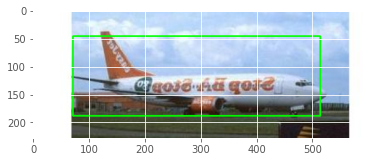

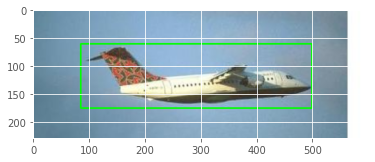

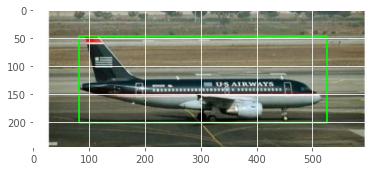

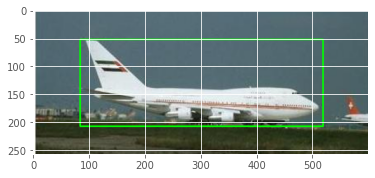

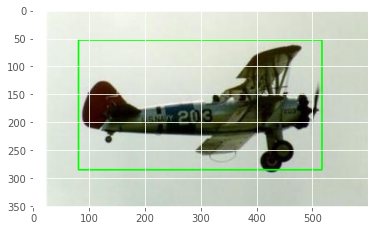

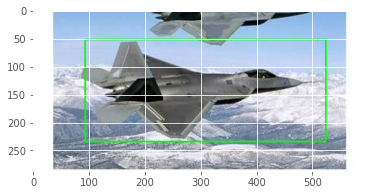

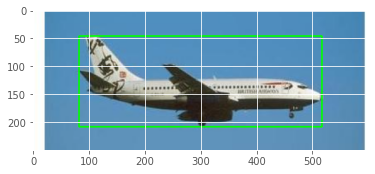

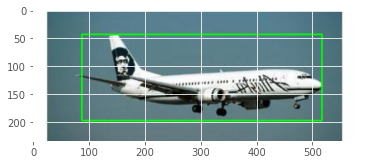

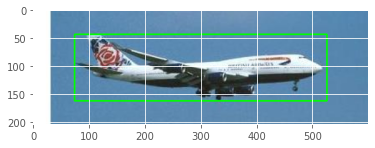

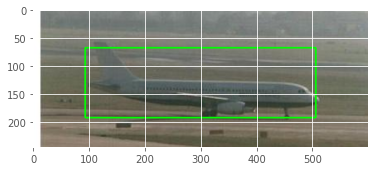

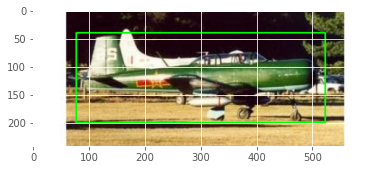

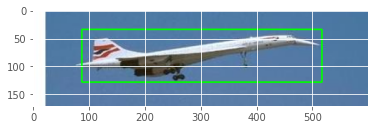

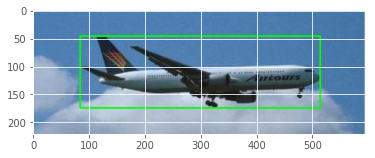

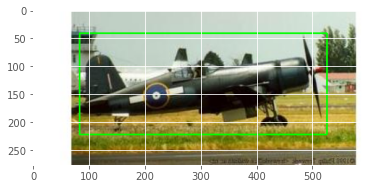

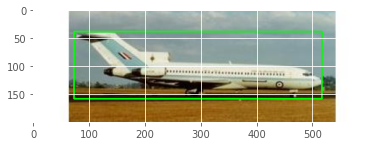

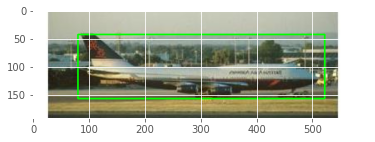

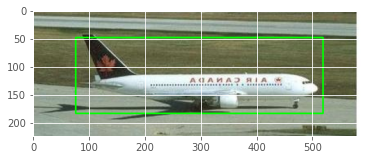

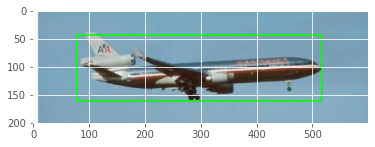

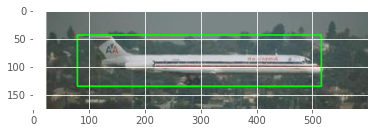

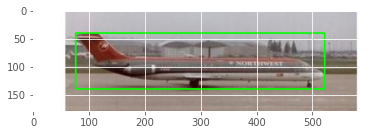

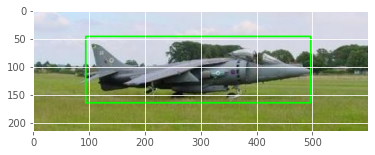

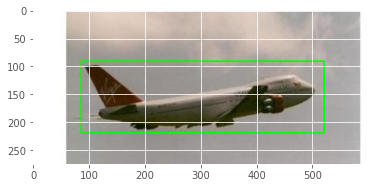

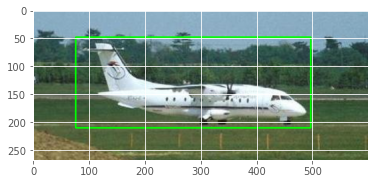

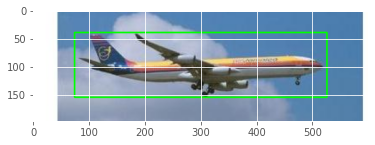

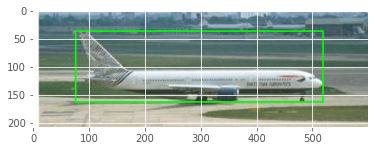

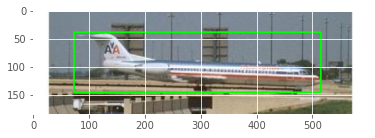

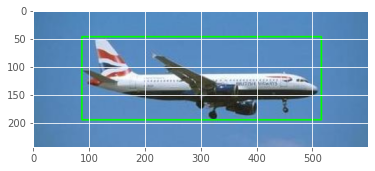

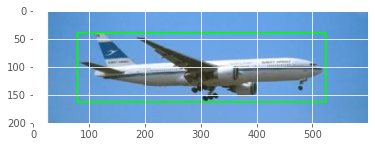

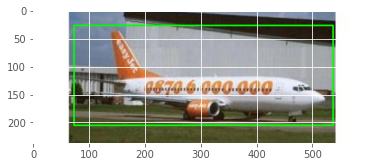

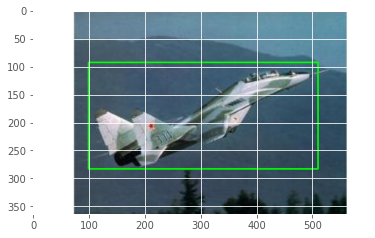

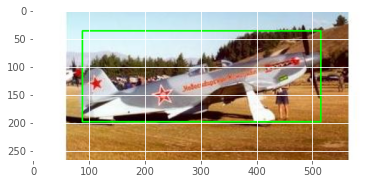

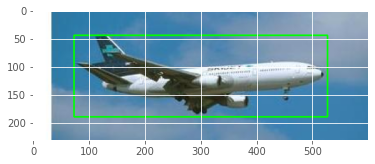

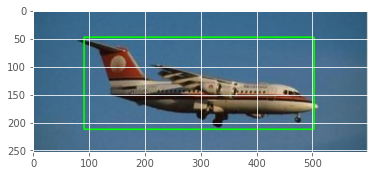

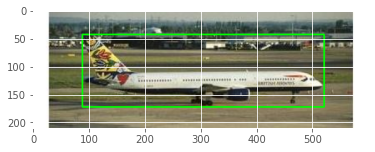

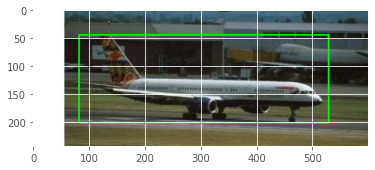

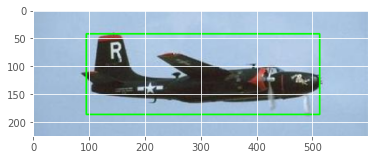

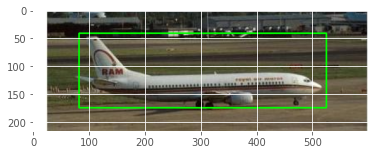

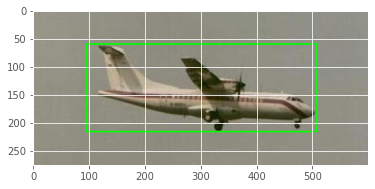

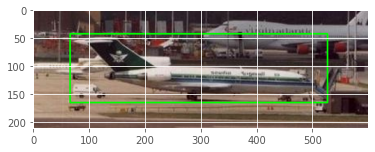

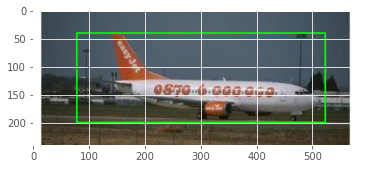

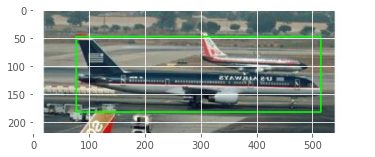

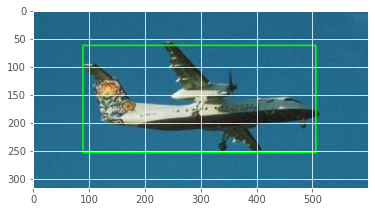

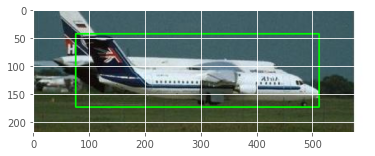

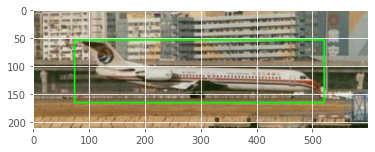

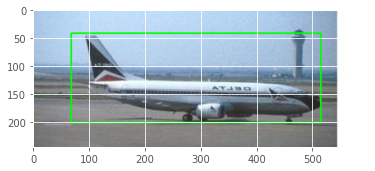

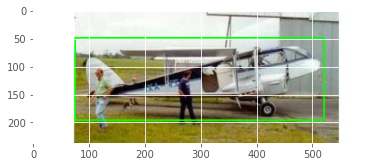

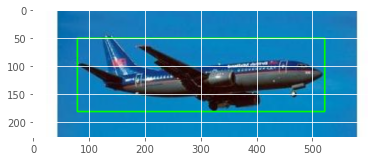

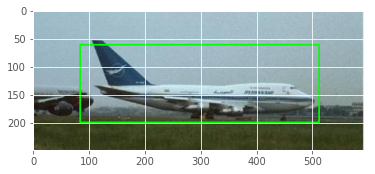

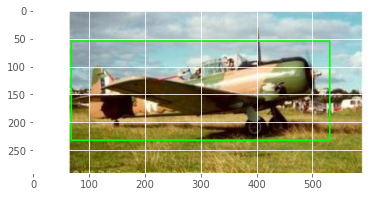

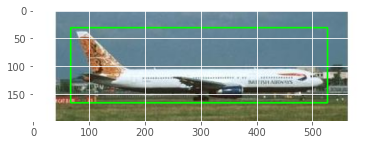

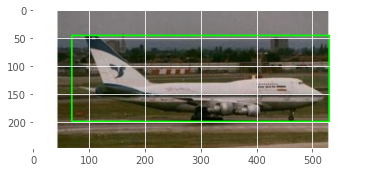

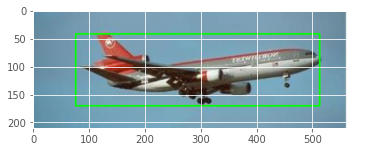

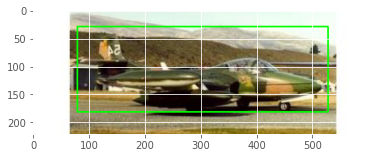

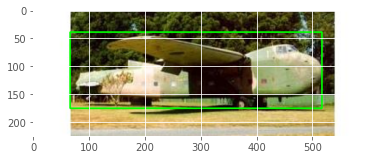

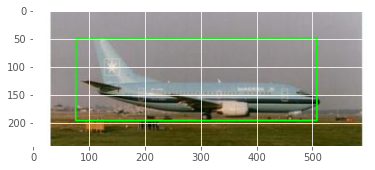

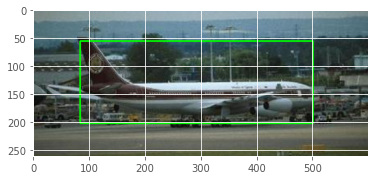

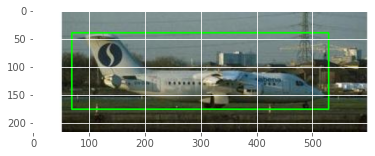

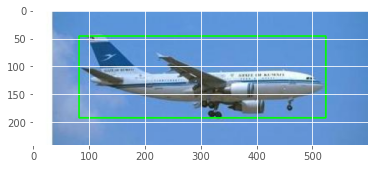

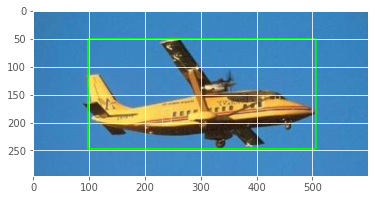

In [32]:
pridicted_images = []
# load our trained bounding box regressor from disk
print("[INFO] loading object detector...")
model = load_model(MODEL_PATH)
# loop over the images that we'll be testing using our bounding box
# regression model
for imagePath in imagePaths:
    # load the input image (in Keras format) from disk and preprocess
    # it, scaling the pixel intensities to the range [0, 1]
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image) / 255.0
    image = np.expand_dims(image, axis=0)

    preds = model.predict(image)[0]
    (startX, startY, endX, endY) = preds
    # load the input image (in OpenCV format), resize it such that it
    # fits on our screen, and grab its dimensions
    image = cv2.imread(imagePath)
    image = imutils.resize(image, width=600)
    (h, w) = image.shape[:2]
    # scale the predicted bounding box coordinates based on the image
    # dimensions
    startX = int(startX * w)
    startY = int(startY * h)
    endX = int(endX * w)
    endY = int(endY * h)
    # draw the predicted bounding box on the image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img = cv2.rectangle(image, (startX, startY), (endX, endY),
        (0, 255, 0), 2)
    plt.imshow(img)
    plt.show()
    